In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from numpy import *
import argparse
from PIL import Image
from class_mapper import CLS2IDX
from timm.models import create_model
import render
import torch
import numpy as np
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, transforms
import vim.models_mamba as models_mamba
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.backends.cudnn as cudnn
from timm.models import create_model

In [25]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)

    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_ours(model, image):
    image.requires_grad_()
    logits = model(image)
    
    index = np.argmax(logits.cpu().data.numpy(), axis=-1)
    one_hot = np.zeros((1, logits.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits)
    model.zero_grad()
    one_hot.backward(retain_graph=True)
    
    attn_vecs = []

    all_layer_attentions = []
    cls_pos = 98
    start_layer=15

    for i in range(len(model.layers)):
        attn_vecs_a = model.layers[i].mixer.attn_vec.detach().cpu()
        attn_vecs_b = model.layers[i].mixer.attn_vec_b.detach().cpu()
        attn_vecs_a[:,:,99:] = attn_vecs_b.flip([-1])[:,:,99:]
        
        s = model.layers[i].get_gradients().squeeze().detach() #[1:, :].clamp(min=0).max(dim=1)[0].unsqueeze(0)

        attn_vecs_a = attn_vecs_a.clamp(min=0)
        # attn_vecs_a = (attn_vecs_a - attn_vecs_a.min()) / (attn_vecs_a.max() - attn_vecs_a.min())
        s = s.clamp(min=0).max(dim=1)[0].unsqueeze(0).detach().cpu()
        s = (s - s.min()) / (s.max() - s.min())

        avg_heads = (attn_vecs_a.sum(dim=1) / attn_vecs_a.shape[1]).detach()
        # avg_heads = (avg_heads - avg_heads.min()) / (avg_heads.max() - avg_heads.min())
        avg_heads = avg_heads * s
        avg_heads = (avg_heads - avg_heads.min()) / (avg_heads.max() - avg_heads.min())

        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    p = rollout[0 , cls_pos , :].unsqueeze(0)
    p = torch.cat([p[:,:cls_pos], p[:,(cls_pos+1):]], dim=-1)
    return p.clamp(min=0).squeeze().unsqueeze(0), logits

In [26]:
from PIL import Image
import torchvision.transforms as transforms

IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]

def transform_for_eval(image_path, input_size=224):
    transform_eval = transforms.Compose([
        transforms.Resize(int(input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])
    img = Image.open(image_path).convert('RGB')
    transformed_img = transform_eval(img)
    return transformed_img

import cv2

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


def generate_visualization(original_image, transformer_attribution):
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_preds(logits):
    prob = torch.softmax(logits, dim=1)
    class_indices = logits.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(logits[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [ ]:
model_name="vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2"

model_ = create_model(
    model_name,
    pretrained=False,
    num_classes=1000,
    drop_rate=0.0,
    drop_path_rate=0.1,
    drop_block_rate=None,
    img_size=224
)

checkpoint_path = './vim_s_midclstok_80p5acc.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_.load_state_dict(checkpoint["model"])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_.to(device)
model_.eval()

for i in range(24):
    model_.layers[i].mixer.saveAttnVec = True

Top 5 classes:
	21 : kite                                                		value = 8.415	 prob = 75.0%
	24 : great grey owl, great gray owl, Strix nebulosa      		value = 5.133	 prob = 2.8%
	22 : bald eagle, American eagle, Haliaeetus leucocephalus		value = 4.807	 prob = 2.0%
	80 : black grouse                                        		value = 4.180	 prob = 1.1%
	82 : ruffed grouse, partridge, Bonasa umbellus           		value = 3.989	 prob = 0.9%


(-0.5, 223.5, 223.5, -0.5)

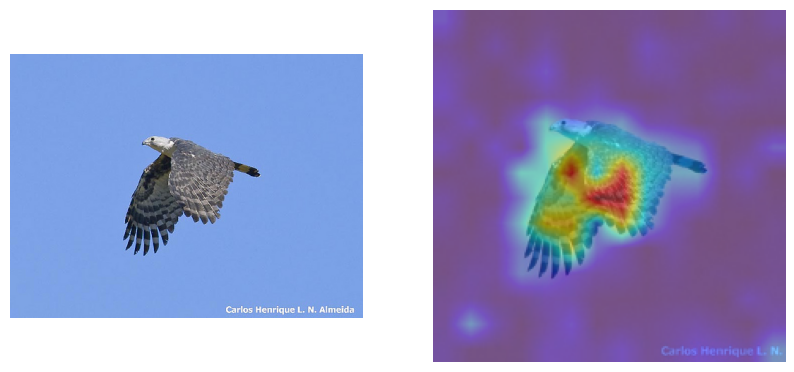

In [30]:
image  = transform_for_eval('./images/1.jpg').unsqueeze(0).cuda()
raw_image = Image.open('./images/1.jpg')
map_mamba_attr, logits = generate_ours(model_, image)

image = image.squeeze()

mamba_attr = generate_visualization(invTrans(image).detach().cpu(), map_mamba_attr)
print_preds(logits)
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(raw_image)
axs[0].axis('off')
axs[1].imshow(mamba_attr)
axs[1].axis('off')